In [ ]:
import os
import time
import json
import numpy as np
import torch
import joblib
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data.trajectory_loader import load_dataset
from models.modified_attention_bi_gru_predictor import TrajPredictor
from utils.logger import get_logger
from utils.model_evaluator import evaluate_metrics_multi_agent_per_timestep as evaluate
from utils.plot_generator import plot_trajectories
from utils.scaler import scale_per_agent

In [3]:
# pylint: disable=all
# Data settings and parameters
DATA_TYPE = "zurich"  # Options: "zurich", "quadcopter", "mixed"
SEQUENTIAL_PREDICTION = True  # If False, model predicts only the last point for FORWARD_LEN steps
AGENTS = 3  # Number of agents or drones
LOOK_BACK = 50  # Number of past time steps to use as input
FORWARD_LEN = 4  # Number of future time steps to predict
FEATURES_PER_AGENT = 3  # x, y, z

# Training parameters
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-3

# Plotting parameters
NUM_PLOTS = 7  # number of plots to generate

In [ ]:
# Setup logger and experiment folder
logger, exp_dir = get_logger()
os.makedirs(exp_dir, exist_ok=True)

logger.info("Experiment started")
logger.info("Experiment folder: %s\n", exp_dir)
logger.info("Dataset: %s\n", DATA_TYPE)
logger.info("Number of drones (agents): %d\n", AGENTS)
logger.info("LOOK_BACK (past steps): %d\n", LOOK_BACK)
logger.info("FORWARD_LEN (future steps): %d\n", FORWARD_LEN)
logger.info("SEQUENTIAL_PREDICTION: %s\n", "True" if SEQUENTIAL_PREDICTION else "False")

2025-09-26 15:35:53,985 - INFO - Experiment started
2025-09-26 15:35:53,986 - INFO - Experiment configuration:
2025-09-26 15:35:53,986 - INFO -   Experiment folder           : experiments/20250926_153553
  Dataset                     : zurich
  Number of drones (agents)   : 3
  LOOK_BACK (past steps)      : 50
  FORWARD_LEN (future steps)  : 4
  SEQUENTIAL_PREDICTION       : Enabled


In [5]:
# Load DataFrame
df = load_dataset(
    DATA_TYPE,
    min_rows=800,
    num_flights=AGENTS,
)

# Prepare sequences
# Track trajectory indices to be used in plotting later
X, y, trajectory_ids = [], [], []

for traj_idx in df["trajectory_index"].unique():
    traj_df = df[df["trajectory_index"] == traj_idx].reset_index(drop=True)

    # Drop trajectory_index for features
    traj_data = traj_df.drop(columns=["trajectory_index"]).values.astype(np.float32)
    n_rows = traj_data.shape[0]

    seq_count = n_rows - LOOK_BACK - FORWARD_LEN + 1
    for i in range(seq_count):
        seq_X = traj_data[i : i + LOOK_BACK]  # shape (LOOK_BACK, features)
        
        # For sequential prediction, predict FORWARD_LEN steps; else just the last step
        if SEQUENTIAL_PREDICTION:
            seq_y = traj_data[i + LOOK_BACK : i + LOOK_BACK + FORWARD_LEN]  # shape (FORWARD_LEN, features)
        else:
            seq_y = traj_data[i + LOOK_BACK + FORWARD_LEN - 1 : i + LOOK_BACK + FORWARD_LEN]  # (1, features)

        X.append(seq_X)
        y.append(seq_y)
        trajectory_ids.append(traj_idx)


In [6]:
# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # (num_sequences, LOOK_BACK, features)
y = np.array(y, dtype=np.float32)  # (num_sequences, 1, features) or (num_sequences, FORWARD_LEN, features)
trajectory_ids = np.array(trajectory_ids)

# Split train/test
X_train, X_test, y_train, y_test, traj_train, traj_test = train_test_split(
    X, y, trajectory_ids, test_size=0.2, shuffle=False
)

# Get feature dimension dynamically
num_features_X = X_train.shape[-1]

# Scale data to [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data only
X_train_scaled = scale_per_agent(X_train, scaler_X, FEATURES_PER_AGENT, fit=True)
X_test_scaled = scale_per_agent(X_test, scaler_X, FEATURES_PER_AGENT, fit=False)

y_train_scaled = scale_per_agent(y_train, scaler_y, FEATURES_PER_AGENT, fit=True)
y_test_scaled = scale_per_agent(y_test, scaler_y, FEATURES_PER_AGENT, fit=False)

# Save scalers
joblib.dump(scaler_X, os.path.join(exp_dir, "scaler_X.pkl"))
joblib.dump(scaler_y, os.path.join(exp_dir, "scaler_y.pkl"))

# Convert to tensors
X_train_tensor = torch.tensor(
    X_train_scaled, dtype=torch.float32
)  # (num_sequences, LOOK_BACK, features)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False
)

In [7]:
# Log dataset sizes
total_sequences = X_train_tensor.shape[0] + X_test_tensor.shape[0]
logger.info("Total sequences: %d", total_sequences)
logger.info("Train sequences: %s", X_train_tensor.shape)
logger.info("Test sequences: %s", X_test_tensor.shape)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("Using device: %s", device)

2025-09-26 15:35:54,438 - INFO - Total sequences: 23157
2025-09-26 15:35:54,439 - INFO - Train sequences: torch.Size([18525, 50, 9])
2025-09-26 15:35:54,440 - INFO - Test sequences: torch.Size([4632, 50, 9])
2025-09-26 15:35:54,441 - INFO - Using device: cpu


In [8]:
# Model, criterion, optimizer
model_params = {
    "enc_hidden_size": 64,
    "dec_hidden_size": 64,
    "num_layers": 1,
}
model = TrajPredictor(**model_params).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Log model info
logger.info("Model module: %s", model.__class__.__module__)
logger.info("Model architecture:\n%s", model)

2025-09-26 15:35:55,438 - INFO - Model module: models.modified_attention_bi_gru_predictor
2025-09-26 15:35:55,439 - INFO - Model architecture:
TrajPredictor(
  (encoder): GRU(3, 64, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=192, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (enc_to_dec): Linear(in_features=128, out_features=64, bias=True)
  (decoder): GRU(131, 64, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)


In [9]:
# Log training time
training_start = time.time()

# Early stopping parameters
patience = 15
best_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Training Loop
model.train()
try:
    for epoch in range(EPOCHS):
        total_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            
            # Add prediction_len argument if sequential prediction
            if SEQUENTIAL_PREDICTION:
                pred = model(batch_x, pred_len=FORWARD_LEN)
            else:
                pred = model(batch_x, pred_len=1)
                
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        logger.info("Epoch %d/%d - Train Loss: %.7f", epoch + 1, EPOCHS, avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(exp_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1

        # If no improvement for 'patience' epochs, stop training
        if epochs_no_improve >= patience:
            logger.info("Early stopping triggered after %d epochs", epoch + 1)
            early_stop = True
            break

except KeyboardInterrupt:
    logger.warning("Training interrupted by user! Running evaluation...")

# Save last-epoch model
finally:
    torch.save(model.state_dict(), os.path.join(exp_dir, "last_model.pt"))

# If training completed without early stopping
if not early_stop:
    logger.info("Training finished without early stopping.")

# Log total training time
training_end_time = time.time()
elapsed_time = training_end_time - training_start
logger.info("Total training time: %.2f seconds", elapsed_time)

2025-09-26 15:36:38,870 - INFO - Epoch 1/500 - Train Loss: 0.0037604
2025-09-26 15:37:20,957 - INFO - Epoch 2/500 - Train Loss: 0.0000311
2025-09-26 15:38:03,367 - INFO - Epoch 3/500 - Train Loss: 0.0000133
2025-09-26 15:38:46,965 - INFO - Epoch 4/500 - Train Loss: 0.0000120
2025-09-26 15:39:32,203 - INFO - Epoch 5/500 - Train Loss: 0.0000149
2025-09-26 15:40:15,257 - INFO - Epoch 6/500 - Train Loss: 0.0000127
2025-09-26 15:40:57,791 - INFO - Epoch 7/500 - Train Loss: 0.0000166
2025-09-26 15:41:39,421 - INFO - Epoch 8/500 - Train Loss: 0.0000116
2025-09-26 15:42:21,670 - INFO - Epoch 9/500 - Train Loss: 0.0000141
2025-09-26 15:43:06,767 - INFO - Epoch 10/500 - Train Loss: 0.0000159
2025-09-26 15:43:53,057 - INFO - Epoch 11/500 - Train Loss: 0.0000167
2025-09-26 15:44:38,410 - INFO - Epoch 12/500 - Train Loss: 0.0000108
2025-09-26 15:45:23,922 - INFO - Epoch 13/500 - Train Loss: 0.0000119
2025-09-26 15:46:11,114 - INFO - Epoch 14/500 - Train Loss: 0.0000117
2025-09-26 15:46:56,075 - INF

In [10]:
# Evaluation parameters
all_preds, all_trues = [], []
inference_times = []
test_loss = 0.0
total_sequences = 0

model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        total_sequences += batch_x.size(0)

        # Measure inference time
        start_time = time.time()
        
        # Add prediction_len argument if sequential prediction
        if SEQUENTIAL_PREDICTION:
            outputs = model(batch_x, pred_len=FORWARD_LEN)
        else:
            outputs = model(batch_x, pred_len=1)
            
        end_time = time.time()

        # Record inference time per batch
        inference_times.append(end_time - start_time)

        # Compute test loss
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Store predictions and true values
        all_preds.append(outputs.cpu())
        all_trues.append(batch_y.cpu())

# Compute average test loss
avg_test_loss = test_loss / len(test_loader)

# Compute total inference time, average inference time per batch and per sequence
total_inf_time = sum(inference_times)
avg_inf_time_per_seq = total_inf_time / total_sequences
avg_inf_time_per_batch = total_inf_time / len(test_loader)

# Log final test metrics
logger.info("Test Loss (scaled): %.7f", avg_test_loss)
logger.info("Average inference time per sequence: %.6f seconds", avg_inf_time_per_seq)
logger.info("Average inference time per batch: %.6f seconds", avg_inf_time_per_batch)

2025-09-26 16:03:34,464 - INFO - Test Loss (scaled): 0.0000177
2025-09-26 16:03:34,465 - INFO - Average inference time per sequence: 0.000952 seconds
2025-09-26 16:03:34,465 - INFO - Average inference time per batch: 0.030406 seconds


In [11]:
# Concatenate all batches
y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_trues, dim=0)

# Compute evaluation metrics (inverse scaling applied)
mse_t, rmse_t, mae_t, ede_t, axis_mse_t, axis_rmse_t, axis_mae_t = evaluate(
    y_true, y_pred, scaler_y, num_agents=AGENTS
)

# --- Table header ---
header = (
    f"{'Timestep':>8} | {'EDE':>10} | {'MSE':>10} | {'RMSE':>10} | {'MAE':>10} | "
    f"{'MSE_x':>10} {'MSE_y':>10} {'MSE_z':>10} | "
    f"{'RMSE_x':>10} {'RMSE_y':>10} {'RMSE_z':>10} | "
    f"{'MAE_x':>10} {'MAE_y':>10} {'MAE_z':>10}"
)
logger.info("-" * len(header))
logger.info(header)
logger.info("-" * len(header))

# --- Table rows ---
for t, (ede, mse, rmse, mae, axis_mse, axis_rmse, axis_mae) in enumerate(
    zip(ede_t, mse_t, rmse_t, mae_t, axis_mse_t, axis_rmse_t, axis_mae_t)
):
    logger.info(
        "%8d | %10.6f | %10.6f | %10.6f | %10.6f | "
        "%10.6f %10.6f %10.6f | "
        "%10.6f %10.6f %10.6f | "
        "%10.6f %10.6f %10.6f",
        t,
        ede,
        mse,
        rmse,
        mae,
        axis_mse[0], axis_mse[1], axis_mse[2],
        axis_rmse[0], axis_rmse[1], axis_rmse[2],
        axis_mae[0], axis_mae[1], axis_mae[2],
    )

# --- Summary averages ---
logger.info("-" * len(header))
logger.info(
    "%8s | %10.6f | %10.6f | %10.6f | %10.6f | "
    "%10.6f %10.6f %10.6f | "
    "%10.6f %10.6f %10.6f | "
    "%10.6f %10.6f %10.6f",
    "Average",
    ede_t.mean(),
    mse_t.mean(),
    rmse_t.mean(),
    mae_t.mean(),
    axis_mse_t.mean(axis=0)[0],
    axis_mse_t.mean(axis=0)[1],
    axis_mse_t.mean(axis=0)[2],
    axis_rmse_t.mean(axis=0)[0],
    axis_rmse_t.mean(axis=0)[1],
    axis_rmse_t.mean(axis=0)[2],
    axis_mae_t.mean(axis=0)[0],
    axis_mae_t.mean(axis=0)[1],
    axis_mae_t.mean(axis=0)[2],
)
logger.info("-" * len(header))

2025-09-26 16:03:36,202 - INFO - ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
2025-09-26 16:03:36,203 - INFO - Timestep |        EDE |        MSE |       RMSE |        MAE |      MSE_x      MSE_y      MSE_z |     RMSE_x     RMSE_y     RMSE_z |      MAE_x      MAE_y      MAE_z
2025-09-26 16:03:36,204 - INFO - ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
2025-09-26 16:03:36,204 - INFO -        0 |   0.983721 |   0.419815 |   0.647931 |   0.449092 |   0.271383   0.961059   0.027005 |   0.520944   0.980336   0.164331 |   0.428032   0.827403   0.091841
2025-09-26 16:03:36,205 - INFO -        1 |   1.877340 |   1.750608 |   1.323106 |   0.896147 |   1.494187   3.695620   0.062023 |   1.222369   1.922399   0.249044 |   1.013811   1.514580   0.160051
2025-

In [12]:
# Save config / hyperparameters
config = {
    "device": str(device),
    "model_module": model.__class__.__module__,
    "model_class": model.__class__.__name__,
    "model_params": model_params,
    "DATA_TYPE": DATA_TYPE,
    "AGENTS": AGENTS,
    "FEATURES_PER_AGENT": FEATURES_PER_AGENT,
    "LOOK_BACK": LOOK_BACK,
    "FORWARD_LEN": FORWARD_LEN,
    "SEQUENTIAL_PREDICTION": SEQUENTIAL_PREDICTION,
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
}

config_path = os.path.join(exp_dir, "config.json")
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)

logger.info("Config saved to %s", config_path)

2025-09-26 16:03:44,064 - INFO - Config saved to experiments/20250926_153553/config.json


True traj shape: (747, 4, 9), Pred traj shape: (747, 4, 9)


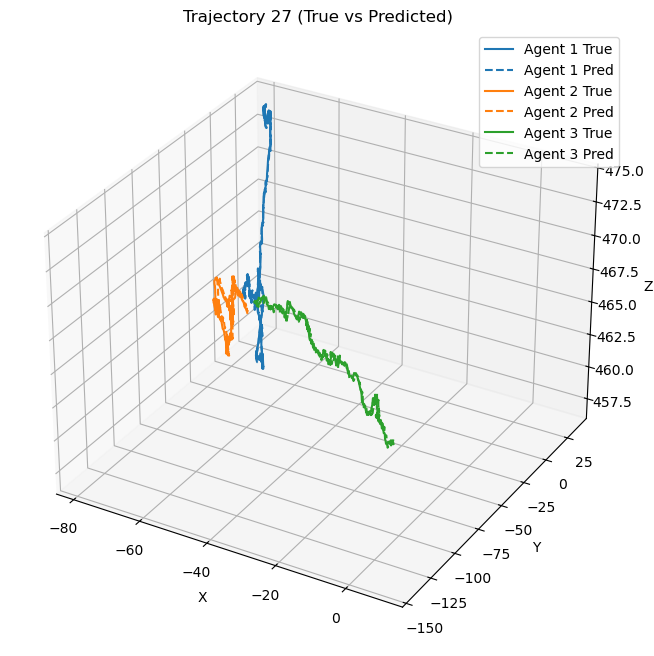

True traj shape: (747, 4, 9), Pred traj shape: (747, 4, 9)


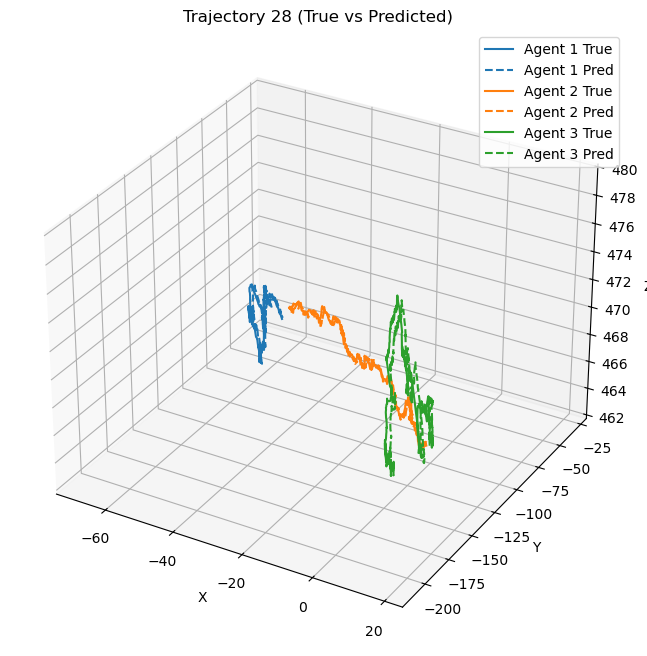

True traj shape: (747, 4, 9), Pred traj shape: (747, 4, 9)


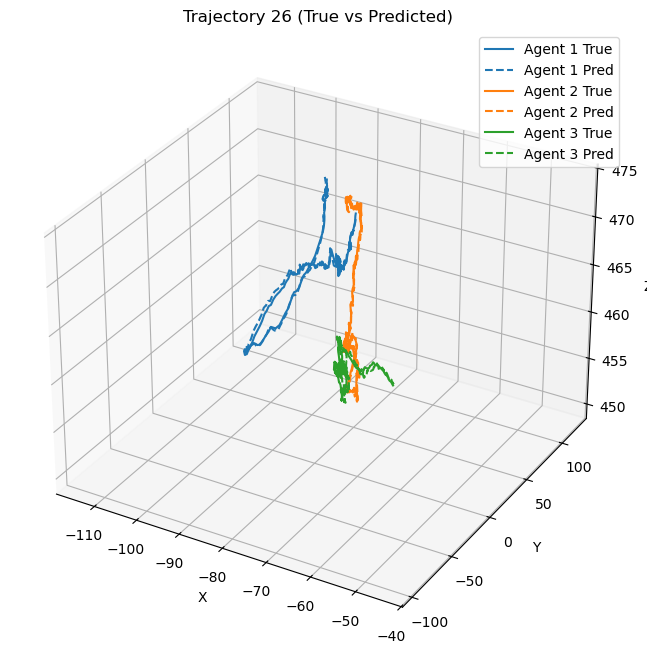

True traj shape: (747, 4, 9), Pred traj shape: (747, 4, 9)


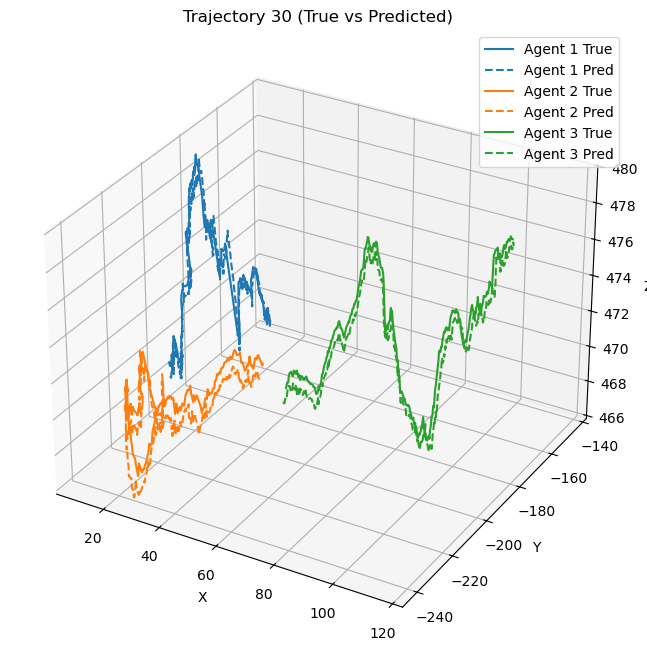

True traj shape: (150, 4, 9), Pred traj shape: (150, 4, 9)


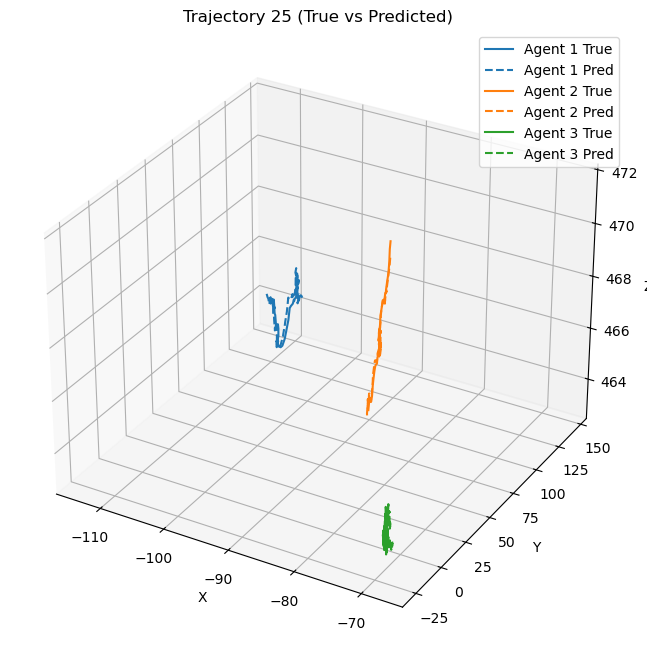

True traj shape: (747, 4, 9), Pred traj shape: (747, 4, 9)


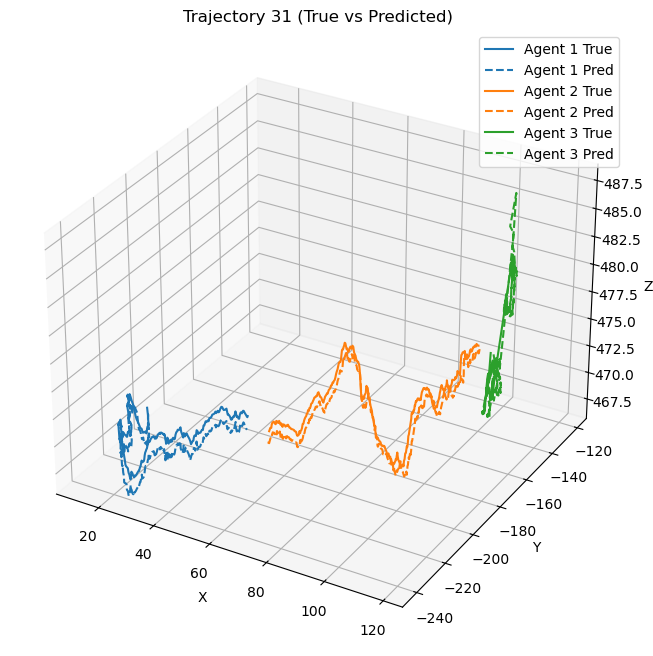

True traj shape: (747, 4, 9), Pred traj shape: (747, 4, 9)


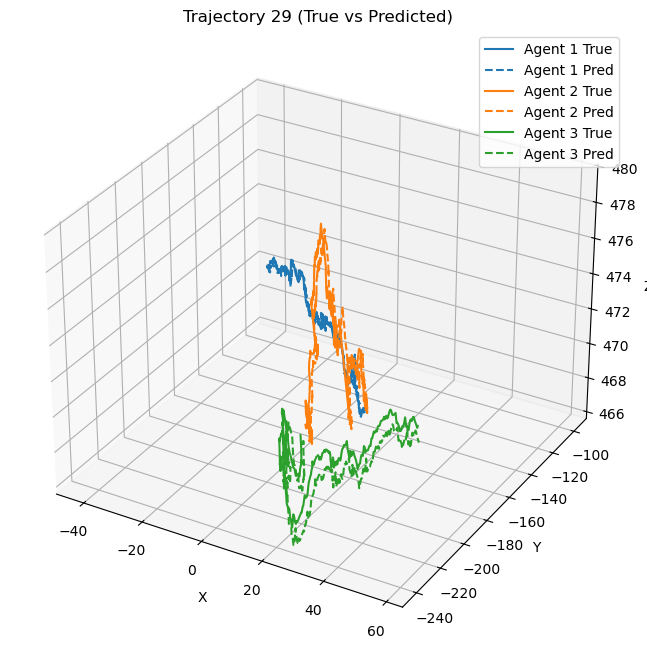

In [13]:
# Group results back by trajectory_index
traj_test = traj_test[: len(y_true)]  # align just in case
unique_trajs = np.unique(traj_test)

# Randomly select trajectories to plot
plot_trajs = np.random.choice(
    unique_trajs, size=min(NUM_PLOTS, len(unique_trajs)), replace=False
).tolist()

# Plot trajectories using the helper function
plot_trajectories(
    y_true=y_true.numpy(),
    y_pred=y_pred.numpy(),
    traj_ids=traj_test,
    plot_trajs=plot_trajs,
    scaler=scaler_y,
    agents=AGENTS,
    save_dir=exp_dir,
)